# (Convolutional) Neural network tutorial - BigMax workshop - Dresden, April 2019


##### Authors: Angelo Ziletti, Andreas Leitherer, and Luca M. Ghiringhelli - Fritz Haber Institute of the Max Planck Society, Berlin

In this tutorial, we briefly introduce the main ideas behind convolutional neural networks, build a neural network model with Keras, and explain the classification decision process using attentive response maps.

## 0. Install packages needed

We first install the packages that we will need to perform this tutorial, and then we load the necessary Python libraries. This tutorial has been tested on Python 3.5.

In [1]:
# packages to build convolutional neural networks (and not only)
! pip install --user tensorflow
! pip install --user keras

# to visualize images
! pip install matplotlib

# to calculate convolution
! pip install scipy
! pip install numpy

# package for neural network attention map visualization
! pip install git+https://github.com/raghakot/keras-vis.git -U

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should

Requirement not upgraded as not directly required: python-dateutil>=2.1 in /home/ziletti/anaconda2/envs/py36/lib/python3.6/site-packages (from matplotlib->keras-vis==0.4.1) (2.7.3)
Requirement not upgraded as not directly required: pytz in /home/ziletti/anaconda2/envs/py36/lib/python3.6/site-packages (from matplotlib->keras-vis==0.4.1) (2018.5)
Requirement not upgraded as not directly required: kiwisolver>=1.0.1 in /home/ziletti/anaconda2/envs/py36/lib/python3.6/site-packages (from matplotlib->keras-vis==0.4.1) (1.0.1)
Requirement not upgraded as not directly required: decorator>=4.1.0 in /home/ziletti/anaconda2/envs/py36/lib/python3.6/site-packages (from networkx>=1.8->scikit-image->keras-vis==0.4.1) (4.3.0)
Requirement not upgraded as not directly required: toolz>=0.7.3; extra == "array" in /home/ziletti/anaconda2/envs/py36/lib/python3.6/site-packages (from dask[array]>=0.9.0->scikit-image->keras-vis==0.4.1) (0.9.0)
Requirement not upgraded as not directly required: setuptools in /ho

In [2]:
from __future__ import print_function
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.misc
import urllib.request

Using TensorFlow backend.


## 1. Introduction to Convolutional Neural Networks 

This introduction is mainly taken from Ref. [1], to which we refer the interested reader for more details.

Convolutional networks are a specialized kind of neural network for processing data that has a known **grid-like topology**; they are networks that use convolution in place of general matrix multiplication in at least one of their layers.

Examples of such data include time-series data (1-D grid with samples at regular time intervals) and image data (2-D grid of pixels).   
Convolutional networks have been tremendously successful in practical applications, especially in computer vision. 

The name "convolutional neural network" indicates that the network employs a mathematical operation called convolution. Convolution is a specialized kind of linear operation. 


A typical layer of a convolutional network consists of three stages:
1. **Convolution** stage: the layer performs several convolutions in parallel to produce a set of linear activations (see Sec. 3 for more details).

2. **Detector** stage: each linear activation is run through a nonlinear activation function (e.g. rectified linear 
activation function, sigmoid or tanh function)

3. **Pooling** stage: a pooling function is used to modify (downsample) the output of the layer. A pooling function replaces the output of the network at a certain location with a summary statistic of the nearby outputs. For example, the max pooling operation reports the maximum output within a rectangular neighborhood. Other popular pooling functions include the average of a rectangular neighborhood, the $L^2$ norm of a rectangular neighborhood, or a weighted average based on the distance from the central pixel.

#### Max pooling example

![maxpool.jpg](maxpool.jpg)
Figure from http://cs231n.github.io/convolutional-networks/


#### Average pooling example

![avg_pooling_example.png](avg_pooling_example.png)
Figure from https://github.com/vdumoulin/conv_arithmetic



### 2. Motivation
Why one should use convolutional neural networks instead of simple (fully connected) neural networks?

Convolution leverages three important ideas that can help improve a machine learning system: 
- **sparse interactions**
- **parameter sharing**
- **equivariant representations**   

Moreover, convolution provides a means for working with inputs of variable size - while this is not possible with fully connected neural networks (also called multi-layer perceptrons).

#### 2.1 Sparse interactions
##### Fully connected NN
It uses matrix multiplication by a matrix of parameters with a separate parameter describing the interaction between each input unit and each output unit. This means that every output unit interacts with every input unit. This do not scale well to full images. For example, an image of 200x200x3 would lead to neurons that have 200x200x3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons. Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.
##### CNN
It achieves sparse interactions (sparse connectivity) by making the kernel smaller than the input. When processing an image, we can detect small, meaningful features such as edges with kernels that occupy only tens or hundreds of pixels. (*see Sec. 3.3.2 for two concrete examples*).   
This means that we need to store fewer parameters, which both reduces the memory requirements of the model and improves its statistical efficiency. It also means that computing the output requires fewer operations. If there are $m$ inputs and $n$ outputs, then matrix multiplication requires $m \times n$ parameters, and the algorithms used in practice have $O(m \times n)$ runtime (per example). If we limit the number of connections each output may have to $k$, then the sparsely connected approach requires only $k \times n$ parameters and $O(k \times n)$ runtime. For many practical applications, $k$ is several orders of magnitude smaller than $m$.

#### 2.2 Parameter sharing
It refers to using the same parameter for more than one function in a model. 

##### Fully connected NN
Each element of the weight matrix is used exactly once when computing the output of a layer.

##### CNN
Each member of the kernel is used at every position of the input. The parameter sharing used by the convolution operation means that rather than learning a separate set of parameters for every location, we learn only one set. This further reduce the storage requirements of the model to $k$ parameters. Recall that $k$ is usually several orders of magnitude smaller than $m$. Since $m$ and $n$ are usually roughly the same size, $k$ is practically insignificant compared to $m \times n$. Convolution is thus dramatically more efficient than dense matrix multiplication in terms of the memory requirements and statistical efficiency.  


#### 2.3 Equivariant representations

Parameter sharing causes the layer to have **equivariance to translation**. To say a function is equivariant means that if the input changes, the output changes in the same way.

When processing time-series data, this means that convolution produces a sort of timeline that shows when different features appear in the input. If we move an event later in time in the input, the exact same representation of it will appear in the output, just later. Similarly with images, convolution creates a 2-D map of where certain features appear in the input. If we move the object in the input, its representation will move the same amount in the output. This is useful for when we know that some function of a small number of neighboring pixels is useful when applied to multiple input locations.

## 3. The convolution operation

### 3.1 Summary and intuition
The convolutional layer's parameters consist of a set of learnable filters. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. For example, a typical filter on a first layer of a ConvNet might have size 5x5x3 (i.e. 5 pixels width and height, and 3 because images have depth 3, the color channels). 

* During the forward pass, we slide (more precisely, convolve) each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. Intuitively, a convolution can be thought as a sliding (weigthed) average.   

* As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or eventually entire honeycomb or wheel-like patterns on higher layers of the network. 

* At this stage, we have an entire set of filters in each convolutional layer (e.g. 12 filters), and each of them produce a separate 2-dimensional activation map. We stack these activation maps along the depth dimension and produce the output volume.

Below, you can see a representation on how the convolution operation is performed.
![AnimationConvolution](padding_strides.gif "convolution")

Animation from: https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif

### 3.2 Mathematical formulation - from Ref. [1]

#### Main idea
Suppose we are tracking the location of a spaceship with a laser sensor. Our laser sensor provides a single output $x(t)$, the position of the spaceship at time $t$. Now suppose that our laser sensor is somewhat noisy. To obtain a less noisy estimate of the spaceship’s position, we would like to average several measurements. Of course, more recent measurements are more relevant, so we will want this to be a weighted average that gives more weight to recent measurements. We can do this with a weighting function $w(a)$, where $a$ is the age of a measurement.    
If we apply such a weighted average operation at every moment, we obtain a new function $s$ providing a smoothed estimate of the position of the spaceship:    

$s(t) = \int x(a)w(t− a)da$

This operation is called **convolution**.   

The convolution operation is typically denoted with an asterisk:    

$s(t) = ( x ∗ w )( t )$

In convolutional network terminology, the first argument (in this example, the function $x$) to the convolution is often referred to as the **input**, and the second argument (in this example, the function $w$) as the **kernel**. The output is sometimes referred to as the **feature map**.

#### Discrete version - 1D [optional]
Let us assume that time index $t$ can then take on only integer values. If we now assume that $x$ and $w$ are defined only on integer $t$, we can define the discrete convolution:   

$s(t) = ( x ∗ w )( t ) = \sum_{a=-\infty}^{+\infty} x(a)w(t− a)$

#### Discrete version - 2D [optional]
$S(i,j) = (I ∗ k)(i,j) = \sum_{m}\sum_{n} I(m,n)K(i-m,j-n)$   

Convolution is commutative, so we can write:    

$S(i,j) = (K ∗ I)(i,j) = \sum_{m}\sum_{n} I(i-m,j-n)K(m,n)$   

Usually the latter formula is more straightforward to implement in a machine learning library, because there is less variation in the range of valid values of $m$ and $n$. The commutative property of convolution arises because we have flipped the kernel relative to the input, in the sense that as $m$ increases, the index into the input increases, but the index into the kernel decreases. The only reason to flip the kernel is to obtain the commutative property. While the commutative property is useful for writing proofs, it is not usually an important property of a neural network implementation.   

Instead, many neural network libraries implement a related function called the cross-correlation, which is the same as convolution but without flipping the kernel:

$S(i,j) = (I ∗ K)(i,j) = \sum_{m}\sum_{n} I(i+m,j+n)K(m,n)$   

Many machine learning libraries implement cross-correlation but call it *convolution*. In the context of machine learning, the learning algorithm will learn the appropriate values of the kernel in the appropriate place, so an algorithm based on convolution with kernel flipping will learn a kernel that is flipped relative to the kernel learned by an algorithm without the flipping.   

## 3.3 Examples

### 3.3.1 Example: computing output value of a discrete convolution (from Ref. [3])
We present below the calculation of the discrete convolution of a 3x3 kernel $K_{\rm ex}$ (with no padding and stride 1):   
$K_{\rm ex} = \begin{pmatrix}
0 & 1 & 2 \\  
2 & 2 & 0 \\  
0 & 1 & 2  
\end{pmatrix}$   

![SegmentLocal](output_discrete_convolution.png "segment")

### 3.3.2 Example: convolution in practice on real images

We now perform a convolution operation on real images. We use a photo of Max Planck, and a Berlin landscape.

In [3]:
# this can be skipped because the images are already saved on the server

# retrieve image of Max Planck from wikipedia
#print("Retrieving picture of Max Planck. Saving image to './img_max_planck.jpg'.")
#urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Max_Planck_1933.jpg/220px-Max_Planck_1933.jpg", "./img_max_planck.jpg")

# retrive a picture of Berlin
#print("Retrieving picture of Berlin landscape. Saving image to './img_berlin_landscape.jpg'.")
#urllib.request.urlretrieve("http://vivalifestyleandtravel.com/images/cache/c-1509326560-44562570.jpg", "./img_berlin_landscape.jpg")

#print("Done.")

We define a function to display images in a single figure; it is not important for the purpose of this tutorial to understand this function implementation.

In [4]:
# function to display multiple images in a single figure
def show_images(images, cols=1, titles=None, cmap='viridis', filename_out=None):
    """Display a list of images in a single figure with matplotlib.

    Taken from https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window

    Parameters:

    images: list of np.arrays
        Images to be plotted. It must be compatible with plt.imshow.

    cols: int,  optional, (default = 1)
        Number of columns in figure (number of rows is
        set to np.ceil(n_images/float(cols))).

    titles: list of strings
        List of titles corresponding to each image.

    """
    plt.clf()
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)
        plt.imshow(image, cmap=cmap)
        a.set_title(title, fontsize=40)
        a.axis('off')  # clear x- and y-axes
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    if filename_out is not None:
        plt.savefig(filename_out, dpi=100, format='png')

In [5]:
# read jpg files as numpy arrays
img_max_planck = plt.imread('./img_max_planck.jpg')[:, :, 0]
img_berlin_landscape = plt.imread('./img_berlin_landscape.jpg')[:, :, 0]

#### Type of Kernels

In Sec. 3.3.1, we used a randomly chosen matrix to perform our convolution; it turns out that there are some "special" kernel matrices that perform specific (and useful) transformation when convoluted with an image.
Below, we present some example of these kernels.

Please visit this page for more details: https://en.wikipedia.org/wiki/Kernel_(image_processing)

$K_{\rm identity } = \begin{pmatrix}
0 & 0 & 0 \\  
0 & 1 & 0 \\  
0 & 0 & 0  
\end{pmatrix}$   

$K_{ \rm boxblur} = \dfrac{1}{9}\begin{pmatrix}
1 & 1 & 1 \\  
1 & 1 & 1 \\  
1 & 1 & 1  
\end{pmatrix}$   

$K_{\rm gaussianblur3x3} = \dfrac{1}{16}\begin{pmatrix}
1 & 2 & 1 \\  
2 & 4 & 2 \\  
1 & 2 & 1  
\end{pmatrix}$   

$K_{\rm gaussianblur5x5} = \dfrac{1}{256}\begin{pmatrix}
1 &  4 &  6 &  4 & 1 \\  
4 & 16 & 24 & 16 & 4 \\  
6 & 24 & 36 & 24 & 6 \\  
4 & 16 & 24 & 16 & 4 \\  
1 &  4 &  6 &  4 & 1 
\end{pmatrix}$  

$K_{\rm vlines} = \begin{pmatrix}
-1 & 2 & -1 \\  
-1 & 2 & -1 \\  
-1 & 2 & -1  
\end{pmatrix}$   

$K_{\rm hlines} = \begin{pmatrix}
-1 & -1 & -1 \\  
 2 &  2 &  2 \\  
-1 & -1 & -1  
\end{pmatrix}$   

$K_{\rm edges} = \begin{pmatrix}
-1 & -1 & -1 \\  
-1 &  8 & -1 \\  
-1 & -1 & -1  
\end{pmatrix}$         

$K_{\rm emboss} = \begin{pmatrix}
-2 & -1 &  0 \\  
-1 &  1 &  1 \\  
 0 &  1 &  2  
\end{pmatrix}$  

Now we apply the convolution operation on both images (photo of Max Planck and the Berlin landscape) using each of the kernel above.
In particular, we use the Scipy function `signal.convolve2d` to perform the convolution.   

Please refer to the Scipy documentation for more details on this function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In [6]:
k_identity = np.array([[0., 0., 0.], 
                       [0., 1., 0.], 
                       [0., 0., 0.]])

k_box_blur = 1./9. * np.array([[1., 1., 1.], 
                              [1., 1., 1.], 
                              [1., 1., 1.]])

k_gauss_blur_3x3 = 1./16.* np.array([[0., 0., 0., 5., 0., 0., 0.],
                              [0., 0., 18., 32., 18., 5., 0.],
                              [0., 18., 64., 100., 64., 18., 0.],
                              [5., 32., 100., 100., 100., 32., 5.],
                              [0., 18., 64., 100., 64., 18., 0.],
                              [0., 5., 18., 32., 18., 5., 0.],
                              [0., 0., 0., 5., 0., 0., 0.]])

k_gauss_blur_5x5 = 1./256.* np.array([[1.,  4.,  6.,  4., 1.],
                                      [4., 16., 24., 16., 4.],
                                      [6., 24., 36., 24., 6.],
                                      [4., 16., 24., 16., 4.],
                                      [1.,  4.,  6.,  4., 1.]])

k_vlines = np.array([[-1., 2., -1.], 
                     [-1., 2., -1.], 
                     [-1., 2., -1.]])

k_hlines = np.array([[-1., -1., -1.], 
                     [ 2.,  2.,  2.], 
                     [-1., -1., -1.]])

k_edges = np.array([[-1., -1., -1.], 
                    [-1.,  8., -1.], 
                    [-1., -1., -1.]])

#the emboss kernel givens the illusion of depth by emphasizing the differences of pixels in a given direction
# in this case, in a direction along a line from the top left to the bottom right.
k_emboss = np.array([[-2., -1., 0.], 
                     [-1.,  1., 1.], 
                     [ 0.,  1., 2.]])


In [7]:
kernels = [k_identity, k_box_blur, k_vlines, k_hlines, k_edges, k_emboss]
titles = ['original', 'box blur', 'vertical lines', 'horizontal lines', 'edges', 'emboss']

# now apply the convolution for each kernel above
max_planck_feature_maps = []
berlin_landscape_feature_maps = []
for kernel in kernels:
    max_planck_feature_maps.append(signal.convolve2d(img_max_planck, kernel, boundary='symm', mode='same'))
    berlin_landscape_feature_maps.append(signal.convolve2d(img_berlin_landscape, kernel, boundary='symm', mode='same'))

<Figure size 432x288 with 0 Axes>

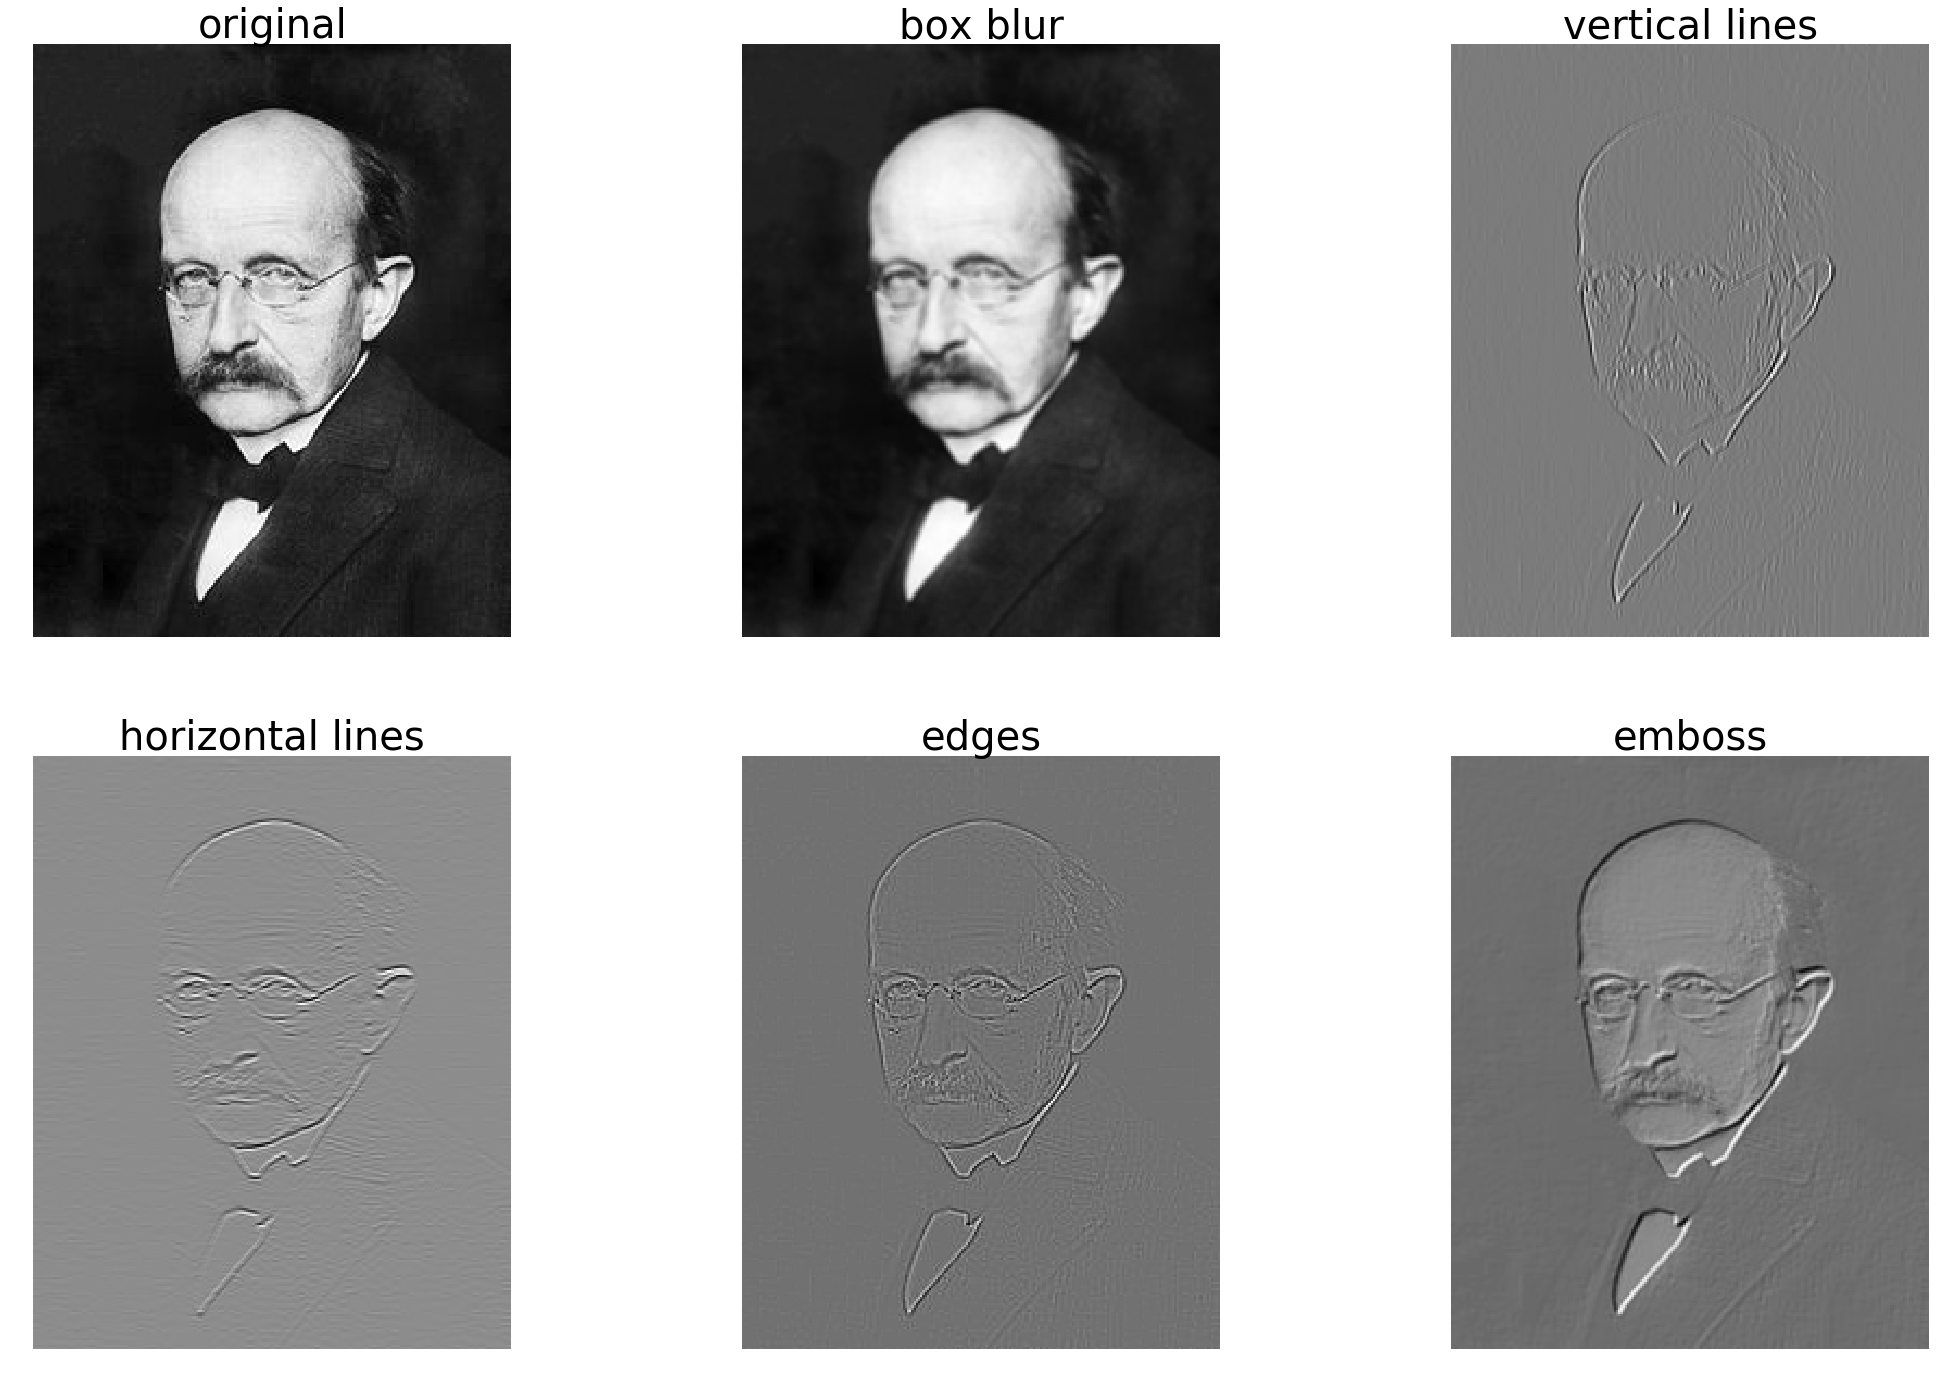

In [8]:
show_images(images=max_planck_feature_maps, cols=2, titles=titles, cmap='gray')

<Figure size 432x288 with 0 Axes>

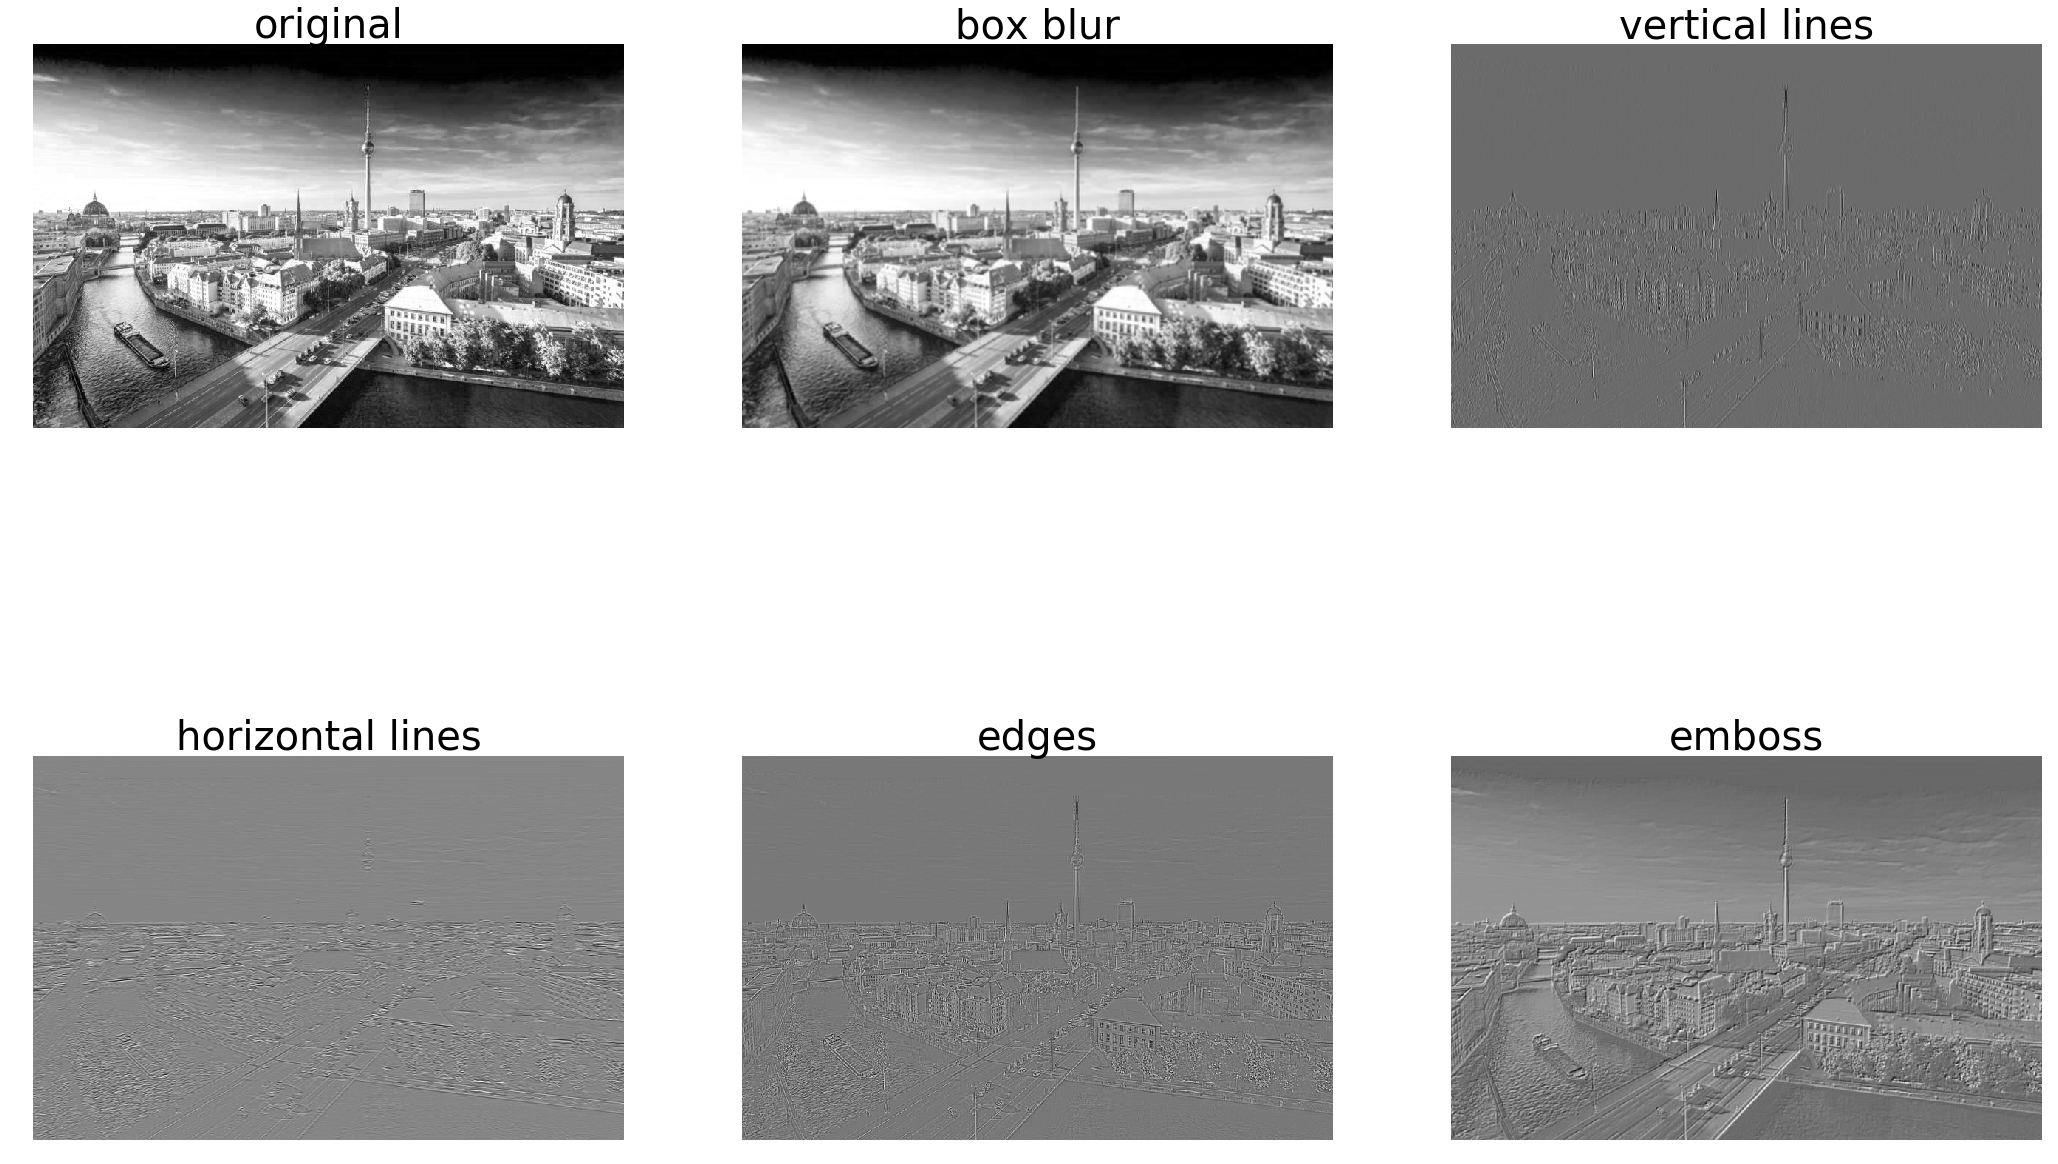

In [9]:
show_images(images=berlin_landscape_feature_maps, cols=2, titles=titles, cmap='gray')

Looking at the pictures above, we notice that each kernel performed a pre-determined modification: 
1. blurring the picture
2. highlighting vertical lines
3. highlighting horizontal lines
4. highlighting edges
5. embossing (i.e. raising the pattern against the background)

As you can see above, the effect are similar for both pictures, and it is defined by the kernel with which the image is convolved.

In the case of **convolutional neural network**, the **kernels** will not be the one reported above, but they are going to be **learned by the network** from the data (by minimizing the classification error). 

## 4. Convolutional neural network model with Keras

Now, we build and train a convolutional neural network.

As an example, we use the well-known MNIST dataset, a database of handwritten digits with training set of 60,000 examples, and a test set of 10,000 examples. 

This is a sample of the hand-written digits present in the database:
![mnist_examples.png](mnist_examples.png)
Figure from https://en.wikipedia.org/wiki/File:MnistExamples.png

If you are interested to know more about this database, please refer to https://en.wikipedia.org/wiki/MNIST_database


### 4.1 Get the MNIST dataset and load it

With the code below, we download the MNIST dataset using the built-in Keras module, and then recast it in numpy arrays.

In [10]:
# this is the code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
batch_size = 128
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### 4.2 Convolutional neural network (without regularization)

We now build a convolutional neural network using Keras, a simple and intuitive high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano; it also runs seamlessly on CPU and GPU.

For more information on Keras, please visit https://keras.io/

We start by defining the architecture (i.e. the shape) of the network. We use two convolutional layers, one max pooling, and one fully connected layer. There is no particular reason behind this choice, and other - better performing - choices are possible.

In [11]:
model_no_reg = Sequential()
model_no_reg.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_no_reg.add(Conv2D(64, (3, 3), activation='relu'))
model_no_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_no_reg.add(Flatten())
model_no_reg.add(Dense(128, activation='relu'))
model_no_reg.add(Dense(num_classes, activation='softmax', name='preds'))

# compile the model before starting training
model_no_reg.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# print a model summary
model_no_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
preds (Dense)                (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


Now, we train the neural network; you can decide the number of epoch you want to use. The more epochs, the more time the network will be able to see the training samples, but this will results in an increase of computational time (proportial to `nb_epochs`).

An **epoch** is a single step in training a neural network; one epoch is completed when the neural network has seen every training sample once. 

<span style="color:red"> **Run the cell below to start training your first convolutional neural network. The full optimization should take approximately 7 minutes (~1 min per epoch); please take this time to read carefully the materials above, and maybe check out some external references.**</span>.

In [12]:
nb_epochs=7     

# train the model for the specified nb_epochs
history_no_reg = model_no_reg.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# evaluate the model performance on the test set
score = model_no_reg.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2028 - acc: 0.9379 - val_loss: 0.0561 - val_acc: 0.9829
Epoch 2/7
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0472 - acc: 0.9859 - val_loss: 0.0360 - val_acc: 0.9881
Epoch 3/7
60000/60000 [==============================] - 66s 1ms/step - loss: 0.0306 - acc: 0.9904 - val_loss: 0.0328 - val_acc: 0.9891
Epoch 4/7
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0207 - acc: 0.9936 - val_loss: 0.0304 - val_acc: 0.9904
Epoch 5/7
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0147 - acc: 0.9953 - val_loss: 0.0298 - val_acc: 0.9892
Epoch 6/7
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0097 - acc: 0.9973 - val_loss: 0.0317 - val_acc: 0.9913
Epoch 7/7
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.0328 - val_acc: 0.991

#### Training history visualization

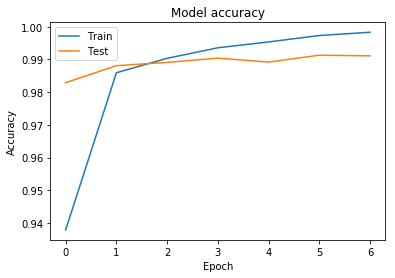

In [13]:
# Plot training & validation accuracy values
plt.plot(history_no_reg.history['acc'])
plt.plot(history_no_reg.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

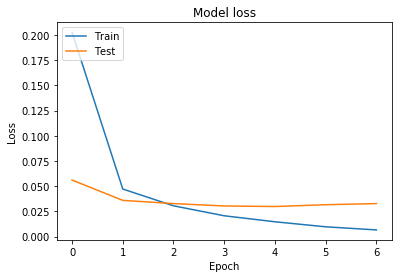

In [14]:
# Plot training & validation loss values
plt.plot(history_no_reg.history['loss'])
plt.plot(history_no_reg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Questions

1. Look at the *Accuracy plot* above. Which information can you gather from it? What is happening to the *training* and *test* accuracy over epochs?
2. Is the behaviour of *training* and *test* accuracy that you are observing desirable? Is *overfitting* occuring?
3. Should you look at the *training* or at the *test* accuracy to have an estimate of the generalization ability of the model?
4. Compare the *Accuracy plot* with the *Model loss plot* below. Do they show the same qualititive behaviour?


### 4.3 Adding regularization (using dropout layers)

To have a valuable machine learning model, it is of paramount important to make sure that the model generalizes well to unseen samples.

Bengio in Ref. [1] defines regularization as *any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error.* In practice, additional terms are added to the training optimization objective to prevent overfitting or help the optimization.

There are numerous ways to regularize a neural network; we refer the interested reader to Chap 7 of Ref. 1: https://www.deeplearningbook.org/contents/regularization.html

Here, we use **dropout layers** to regularize our neural network. To explain in a few word what dropout is, we report below the abstract from the article that introduced dropout (Srivastava et al., J. Mach. Learn. Res. 15 1929 (2014))

*Deep neural nets with a large number of parameters are very powerful machine learning systems. However, overfitting is a serious problem in such networks. Large networks are also slow to use, making it difficult to deal with overfitting by combining the predictions of many different large neural nets at test time. Dropout is a technique for addressing this problem.*

*The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights.*

*This significantly reduces overfitting and gives major improvements over other regularization methods. We show that dropout improves the performance of neural networks on supervised learning tasks in vision, speech recognition, document classification and computational biology, obtaining state-of-the-art results on many benchmark data sets.*

For the full article "Srivastava et al., Dropout: A Simple Way to Prevent Neural Networks from Overfitting", please visit http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf.




In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # dropout layer to regularize
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # dropout layer to regularize
model.add(Dense(num_classes, activation='softmax', name='preds'))

# compile the model before starting training
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# print a model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

 <span style="color:red"> **Run the cell below to start training your *regularized* convolutional neural network. The full optimization should take approximately 7 minutes (~1 min per epoch); please take this time to read carefully the materials above, and maybe check out some external references.**</span>.

In [16]:
nb_epochs=7     

# train the model for the specified nb_epochs
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# evaluate the model performance on the test set
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 74s 1ms/step - loss: 0.2644 - acc: 0.9187 - val_loss: 0.0577 - val_acc: 0.9808
Epoch 2/7
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0911 - acc: 0.9733 - val_loss: 0.0403 - val_acc: 0.9866
Epoch 3/7
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0678 - acc: 0.9794 - val_loss: 0.0347 - val_acc: 0.9887
Epoch 4/7
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0551 - acc: 0.9832 - val_loss: 0.0294 - val_acc: 0.9894
Epoch 5/7
60000/60000 [==============================] - 73s 1ms/step - loss: 0.0469 - acc: 0.9859 - val_loss: 0.0302 - val_acc: 0.9894
Epoch 6/7
60000/60000 [==============================] - 73s 1ms/step - loss: 0.0404 - acc: 0.9877 - val_loss: 0.0300 - val_acc: 0.9893
Epoch 7/7
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0349 - acc: 0.9892 - val_loss: 0.0298 - val_acc: 0.990

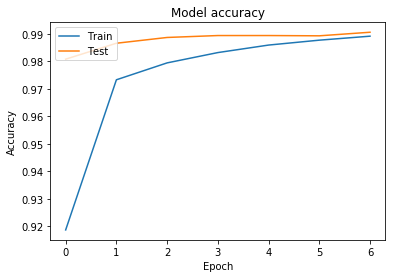

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

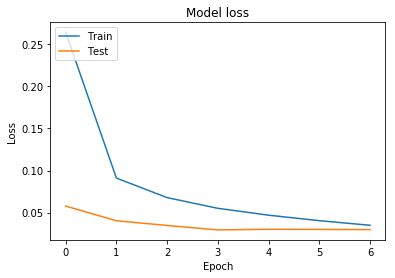

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Questions

1. Which changes do you see between the training history of the previous (unregularized) and the current (regularized) neural network?
2. If you had to pick one neural network out of the two, which one would you choose and why?
3. How important is regularization? Is it optional or a must for having generalizable models?

## 5. Opening the black box with attentive response maps

In the previous section, we built a model which classifies the handwritten digits of the MNIST dataset with satisfactory accuracy. But how can we assess which parts of a given image the network utilizes to arrive at its classification decision?

To answer this question, in this tutorial we will compute **attentive response maps**.

The main idea is to invert the data flow of a convolutional neural network, going from the last layers activations until image space. Then, an heatmap is constructed to shows which parts of the input image are most strongly activating when a classification decision is made - and thus are the most discriminative. 

Specifically, in this tutorial we will use **guided back-propagation**, as introduced in J. Springenberg, A. Dosovitskiy, T. Brox, and Riedmiller, *Striving for Simplicity: The All Convolutional Net*, https://arxiv.org/pdf/1412.6806.pdf (2015), and implemented in the Keras-vis package (https://raghakot.github.io/keras-vis/)

This is not the only technique to explain the classification decisions made by convolutional neural networks; some useful references are listed below:

1. M.D. Zeiler, and R. Fergus, *Visualizing and Understanding Convolutional Networks* 818-833,  https://doi.org/10.1007/978-3-319-10590-1_53 (2014).

2. K. Simonyan, A. Vedaldi, and A. Zisserman, *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps* (2014) (https://arxiv.org/pdf/1312.6034v2.pdf)

3. S. Bach, et al. *On pixel-wise explanations for nonlinear classifier decisions by layer-wise relevance propagation*, PLoS ONE 10, e0130140 (2015).

4. G. Montavon, S. Lapuschkin, A. Binder, W. Samek, and K.R. Müller, *Explaining nonlinear classification decisions with deep Taylor decomposition. Pattern Recognit.* 65, 211–222 (2017).

5. R.R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra, *Visual Explanations from Deep Networks via Gradient-based Localization*, https://arxiv.org/pdf/1610.02391.pdf (2017)

6. Kumar, D., Wong, A. & Taylor, G. W. Explaining the unexplained: a class-enhanced attentive response (CLEAR) approach to understanding deep neural networks. In 2017 IEEE Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 1686–1694 (IEEE, Honolulu, HI, 2017).

For an application of convolutional neural network interpretation to a materials science problem:

7. A. Ziletti, D. Kumar, M. Scheffler, and L. M. Ghiringhelli, *Insightful classification of crystal structures using deep learning*, Nature Communications 9, 2775 (2018)

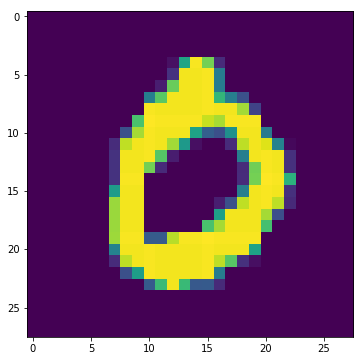

In [19]:
class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(x_test[idx][..., 0])

In [20]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

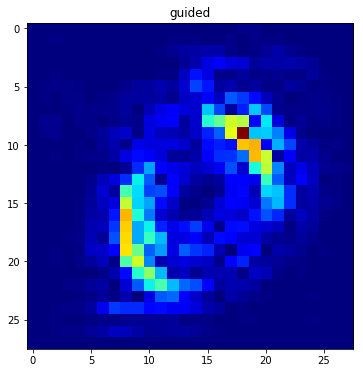

In [21]:
for modifier in ['guided']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

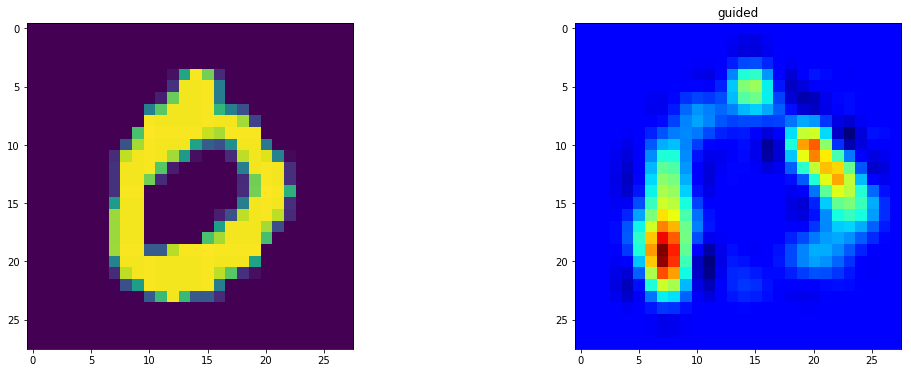

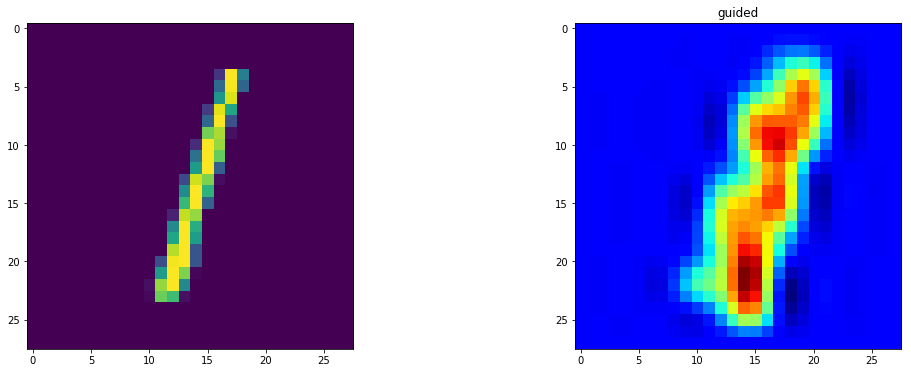

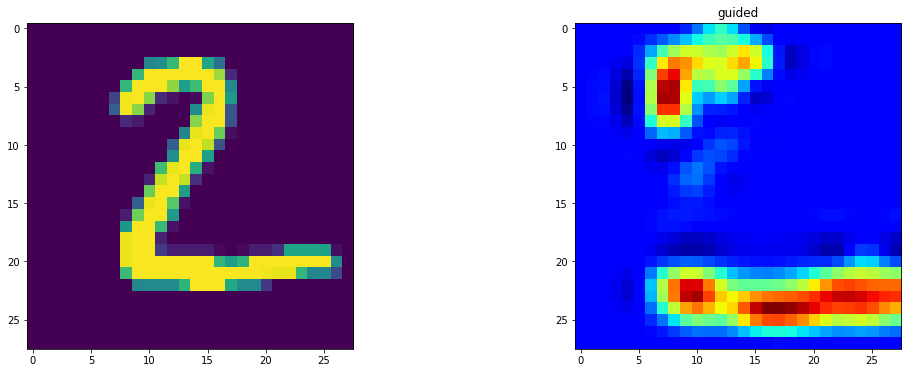

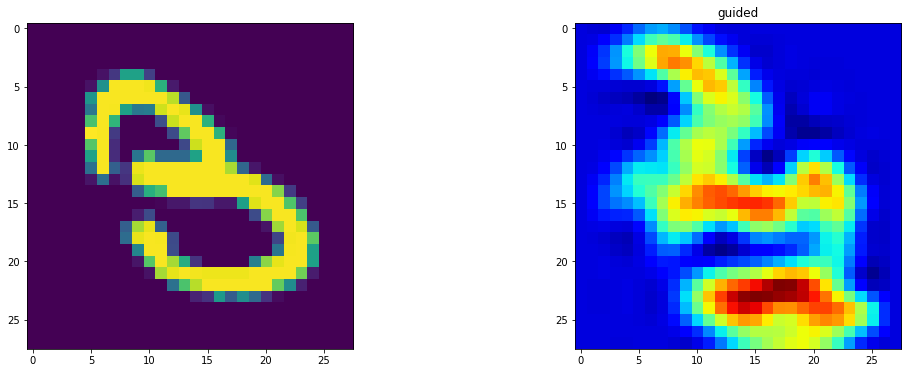

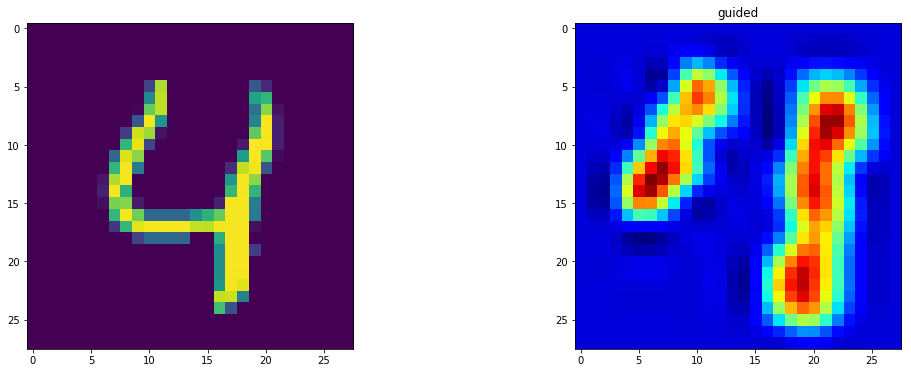

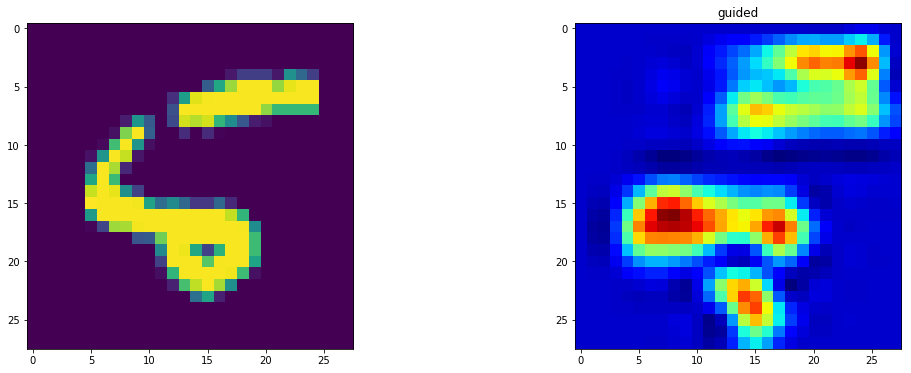

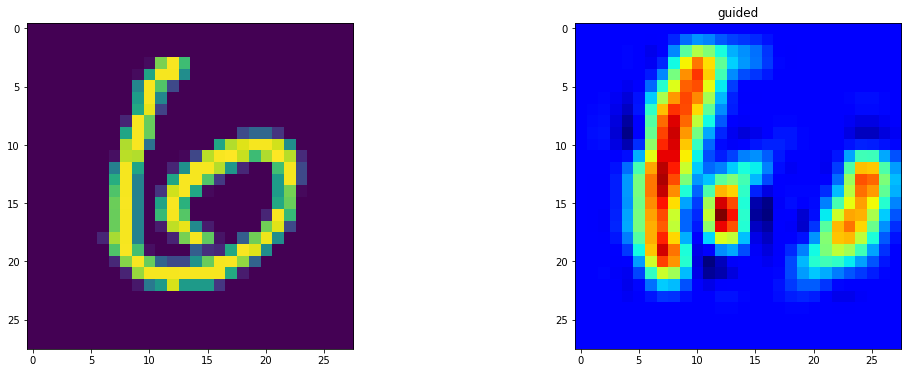

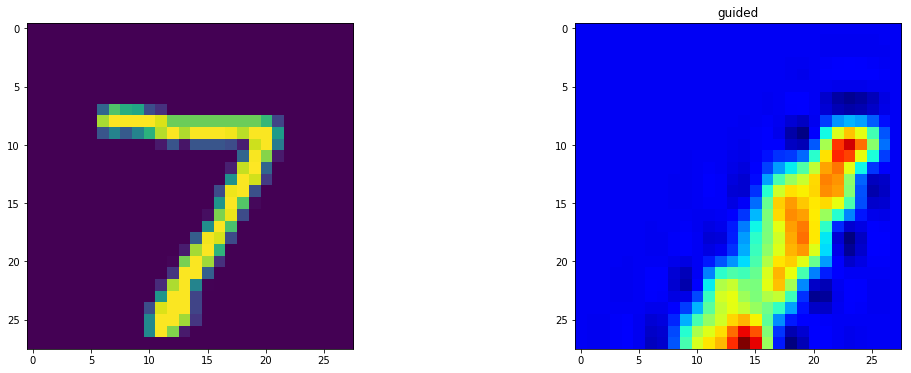

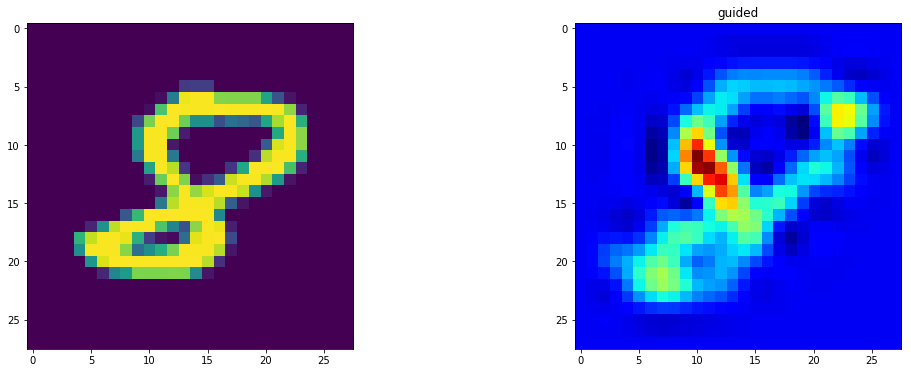

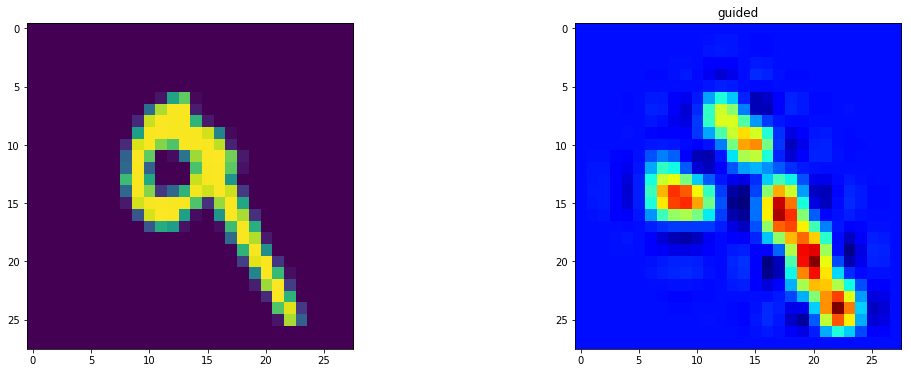

In [22]:
from vis.visualization import visualize_cam

for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate(['guided']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        

        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

#### Questions

1. Have a look at the attentive response maps. Do they look reasonable? How to you evaluate their quality?
2. Try to train another neural network - even a bad one - and calculate its attentive response maps. Are they similar to the one of this network? 
3. Are there materials-science-oriented applications of this technique that can be useful in your research?

## References:

1. *Deep learning*, Goodfellow, Bengio, Courville, MIT Press 2016, Chap. 9 http://www.deeplearningbook.org/contents/convnets.html
2. *A guide to convolution arithmetic for deep learning*, Article: https://arxiv.org/abs/1603.07285; Github: https://github.com/vdumoulin/conv_arithmetic  
3. CS231n Convolutional Neural Networks for Visual Recognition (Stanford University): http://cs231n.github.io/convolutional-networks/
4. Code from MNIST example: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
5. Keras-vis MNIST example: https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb